In [351]:
import requests
import pandas as pd
import numpy as np
from tqdm import tqdm

In [513]:
class Data:
    def __init__(self, ticker, n):
        self.base_url = "https://query2.finance.yahoo.com/v7/finance/options/" + str(ticker)
        self.n = n
        
    def get_input_data(self):
        # Get required input data for the options values
        r = requests.get(self.base_url).json()
        data = r['optionChain']['result'][0]
        dates = data['expirationDates']
        strikes = data['strikes']
        mid_price = np.mean([data['quote']['bid'], data['quote']['ask']])
        
        # Filter for closest ATM strikes
        get_closest_strike = min(range(len(strikes)), key=lambda i: abs(strikes[i]- mid_price))
        
        closest_ATM_indexes = list(range(get_closest_strike - self.n, 
                                         get_closest_strike + self.n))
        
        closest_ATM_strikes = [strikes[i] for i in closest_ATM_indexes]
        
        return dates, closest_ATM_strikes

    def get_vol_data(self):
        # Now iterate through each date and get the mean IV for the closest ATM strikes
        dates = self.get_input_data()[0]
        atm_strikes = self.get_input_data()[1]
        key = ['calls', 'puts']
        
        mean_implied_vol = []
        
        for date in tqdm(dates):
            try:
                url = self.base_url + "?date=" + str(date)
                print(date)
                data = requests.get(url).json()['optionChain']['result'][0]['options'][0]
                options = [data.get(key) for key in keys]
                calls, puts = pd.DataFrame(options[0]), pd.DataFrame(options[1])
                df = pd.concat([calls, puts], axis=0)
                mean_implied_vol.append(df[df['strike'].isin(atm_strikes)].mean()['impliedVolatility'])
            except:
                continue

        return dates, mean_implied_vol


In [542]:
d = Data('AAPL', 5)
iv_term = d.get_vol_data()

  0%|          | 0/15 [00:00<?, ?it/s]

1590105600


/Users/samneet/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  7%|▋         | 1/15 [00:01<00:16,  1.18s/it]

1590710400


 13%|█▎        | 2/15 [00:01<00:12,  1.06it/s]

1591315200


 20%|██        | 3/15 [00:02<00:12,  1.01s/it]

1591920000


 27%|██▋       | 4/15 [00:04<00:13,  1.25s/it]

1592524800


 33%|███▎      | 5/15 [00:05<00:12,  1.26s/it]

1593129600


 40%|████      | 6/15 [00:06<00:10,  1.19s/it]

1594944000


 47%|████▋     | 7/15 [00:07<00:07,  1.09it/s]

1600387200


 53%|█████▎    | 8/15 [00:08<00:07,  1.13s/it]

1602806400


 60%|██████    | 9/15 [00:10<00:07,  1.22s/it]

1608249600


 67%|██████▋   | 10/15 [00:11<00:05,  1.16s/it]

1610668800


 73%|███████▎  | 11/15 [00:11<00:03,  1.11it/s]

1623974400


 80%|████████  | 12/15 [00:12<00:02,  1.06it/s]

1631836800


 87%|████████▋ | 13/15 [00:13<00:01,  1.11it/s]

1642723200


 93%|█████████▎| 14/15 [00:14<00:00,  1.06it/s]

1655424000


100%|██████████| 15/15 [00:14<00:00,  1.00it/s]


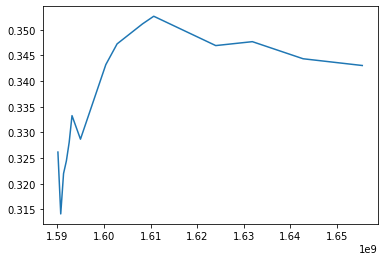

In [544]:
plt.plot(pd.DataFrame(iv_term).T[0],
         pd.DataFrame(iv_term).T[1])         